# Part 0: Initialising

In [44]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap('nipy_spectral')

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")

To start with, we import three datasets that are available from YouNiverse:

``df_channels_en.tsv.gz``   
``df_timeseries_en.tsv.gz``   
``yt_metadata_helper.feather``

To start with, we will filter the channels that have been identified as Gaming, as it is our target category. We will do this by identifying the channel IDs with label ``Gaming`` in ``Category`` from ``df_channels_en.tsv.gz``.

In [45]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

df_channels = df_channels[df_channels['category_cc'] == "Gaming"]
channel_id_gaming = df_channels.channel

``channel_id_gaming`` contains all channel IDs that are identified as Gaming.  we will then use this list to do initial filtering of both ``df_time_series`` and ``video_metadatas``.

In [47]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
df_time_series = df_time_series[
    df_time_series['channel'].isin(channel_id_gaming)
]

In [49]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id"
    ],
)

# we added these two columns for analysis later on.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
video_metadatas = video_metadatas[
    video_metadatas['channel_id'].isin(channel_id_gaming)
]

In [50]:
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA,SBqSc91Hn9g,2016,2
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA,UuugEl86ESY,2016,2
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA,oB4c-yvnbjs,2016,2
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA,ZaV-gTCMV8E,2016,2
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA,cGvL7AvMfM0,2016,2


We now have filtered ``df_channels``, ``df_time_series`` and ``video_metadatas``. However, they have different numbers of channels. ``df_channels`` and ``video_metadatas`` both have 20143 channels, whereas ``df_time_series`` has 19698 channels. 

When we look closer to the data, we can observe that `df_time_series` only has data from early January 2015 to end September 2019, which could be one reason causing the inconsistency. Therefore, we will then filter videos in  ``video_metadatas`` that are being uploaded from early January 2015 to end September 2019 to keep consistency across three dataframes.

In [54]:
video_metadatas = video_metadatas[ (video_metadatas['upload_date'] > df_time_series.datetime.min()) & 
                                   (video_metadatas['upload_date'] < df_time_series.datetime.max()) ]

We now have a list of Gaming channels and the information about their videos. Now, we will proceed to filter out the channels that fit the following conditions:

- The channel has more than XX % of gaming videos
- The YouTuber uploaded with an average frequency of "every XX days or less" AND "every XX days or more"

The reasoning behind these filtering criteria is that we want to have channels that are mainly focusing on gaming, and upload videos not too often but also not too infrequent. Channels with high frequency of upload rate is not likely to be achieved by a single person, and channels that upload too infrequent is likely to be abandoned.

We will achieve this filtering by looking at ``video_metadatas``, and calculate:

- The number of videos being labelled as "Gaming" in each channel
- The number of videos being uploaded to each channel
- The time frame within which the YouTuber is active (corresponding to the number of days between the first and last uploads)


In [55]:
# The number of videos being labelled as "Gaming" in each channel
video_metadatas['is_gaming'] = (video_metadatas.categories == "Gaming")

# The number of videos being uploaded to each channel
count_per_channel = pd.DataFrame(video_metadatas.groupby("channel_id").count().categories).reset_index().rename(columns={"categories":"nr_videos"})
game_video_count_per_channel = pd.DataFrame(video_metadatas.groupby("channel_id").sum().is_gaming).reset_index()

# merge these two datasets
channel_selection = count_per_channel.merge(game_video_count_per_channel)

# The percentage of gaming videos within each channel
channel_selection["pct_gaming"] = channel_selection.is_gaming / channel_selection.nr_videos

In [56]:
pct_level = 0.6  # adjust the percentage of videos being labelled as "Gaming" here
selected_channels = list(channel_selection[channel_selection['pct_gaming'] >= pct_level ].channel_id)

In [57]:
len(selected_channels)

18230

After the filtering, we now have 18230 channels. 

We now want to filter out the channels that upload videos too frequently or too infrequent:

In [75]:
# The time frame within which the YouTuber is active
last_vid_date = pd.DataFrame(video_metadatas.groupby("channel_id").max().
                             upload_date).reset_index().rename(columns={"upload_date":"last_vid_date"})
first_vid_date = pd.DataFrame(video_metadatas.groupby("channel_id").min().
                              upload_date).reset_index().rename(columns={"upload_date":"first_vid_date"})
total_vids = pd.DataFrame(video_metadatas.groupby("channel_id").count().
                          display_id).reset_index().rename(columns={"display_id":"total_vids"})

In [59]:
channel_selection = first_vid_date.merge(last_vid_date)
channel_selection = channel_selection.merge(total_vids)
channel_selection['active_days'] = (channel_selection.last_vid_date - channel_selection.first_vid_date).dt.days
channel_selection['upload_interval'] = channel_selection.active_days / channel_selection.total_vids

In [60]:
min_upload_interval = 2 # in days, the channel upload videos on average every x days 
max_upload_interval = 90
selected_channels = list(channel_selection[(channel_selection['upload_interval'] > min_upload_interval) & 
                                           (channel_selection['upload_interval'] < max_upload_interval) ].channel_id)

In [61]:
len(selected_channels)

14730

Here, we filtered out channels that uploaded videos every 2 days or less. Now we have 14730 channels.

Note that `df_time_series` contains less channels than `df_channels` and `video_metadatas`. In order to keep consistency, we will take the channels that can be found across three dataframes.

In [62]:
df_time_series = df_time_series[df_time_series['channel'].isin(selected_channels)]

In [63]:
selected_channels = list(df_time_series.groupby("channel").count().reset_index().channel)

In [64]:
len(selected_channels)

14380

In [65]:
df_channels = df_channels[df_channels['channel'].isin(selected_channels)]

In [66]:
len(df_channels)

14380

In [67]:
video_metadatas = video_metadatas[video_metadatas['channel_id'].isin(selected_channels)]

In [68]:
len(video_metadatas.groupby("channel_id").count())

14380

We also import a dataset that is created by us, .......  

We will filter the channels and videos that we selected so far.

In [69]:
title_metadatas = pd.read_feather(
    "./data/yt_metadata_title_helper.feather")

title_metadatas = title_metadatas[
    title_metadatas['display_id'].isin(video_metadatas.display_id)
]

In [70]:
# Save title_metadatas in feather 
title_metadatas.to_feather("./data/yt_metadata_title_filtered.feather")

ValueError: feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s)

In [71]:
video_metadatas.shape

(3139186, 11)

In [72]:
title_metadatas.shape

(3139186, 3)

In [73]:
tag_metadatas = pd.read_feather(
    "./data/yt_metadata_tags_helper.feather")

tag_metadatas = tag_metadatas[
    tag_metadatas['display_id'].isin(video_metadatas.display_id)
]

In [74]:
tag_metadatas.head()

,categories,display_id,tags
1792,Gaming,M0x6TJmMwL4,"video,games,retrogamer3,ed,findlay,Blasphemous..."
1793,Gaming,ofAIp6dad00,"video,games,retrogamer3,ed,findlay,Sega,Genesi..."
1794,Gaming,cXHRNThI27A,"video,games,retrogamer3,ed,findlay,Disenchantm..."
1795,Gaming,cDSo3mUNEEM,"video,games,retrogamer3,ed,findlay,Death Stran..."
1796,Gaming,rJmT1Rq24qE,"video,games,retrogamer3,ed,findlay,Friday the ..."


# Part 2: Further Analysis Milestone 3

Given the results in Part 1 of our Analysis, we decided to focus on the categories of Gaming. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, People & Blogs, Comedy, Movies and Shows. We decided to investigate the three categories mentioned above also because videos uploaded can be addressed to audiences of all three categories.

## Key Questions:
 - Which factors help a YouTuber in Gaming gain more subscribers?
 - How do sentiments in titles and tags affect views and how do these relationships change over time?

### Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?  
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022  
**Organization:** Wenxiu  

In [76]:
# we also want to filter out channels that upload too frequently, as we are interested in things that could be done by an individual
avg_upload_weekday = pd.DataFrame(video_metadatas.groupby("channel_id").mean().
                             weekNumber).reset_index().rename(columns={"weekNumber":"avg_upload_weekday"})

avg_video_duration = pd.DataFrame(video_metadatas.groupby("channel_id").mean().
                             duration).reset_index().rename(columns={"duration":"avg_video_duration"})

In [77]:
channel_selection = channel_selection[channel_selection['channel_id'].isin(selected_channels) ]
channel_selection = channel_selection.merge(avg_upload_weekday)
channel_selection = channel_selection.merge(avg_video_duration)
channel_selection = channel_selection.merge(df_channels.loc[:,['channel', 'subscribers_cc']].rename(
    columns={"channel":"channel_id"}))

In [78]:
model_data = channel_selection.loc[:,['upload_interval', 'avg_upload_weekday', 'avg_video_duration', 'subscribers_cc']]

In [79]:
# normalise the data
xmean = np.mean(model_data,axis=0)
xstd = np.std(model_data,axis=0)
Xbzs = (model_data-xmean)/xstd

In [80]:
Xbzs.head(9)

,upload_interval,avg_upload_weekday,avg_video_duration,subscribers_cc
0,-0.447864,-0.698482,5.425201,-0.210988
1,-0.098164,0.932943,-0.485641,-0.211463
2,2.169822,1.192441,-0.457429,-0.176890
3,-0.384435,-0.226633,-0.208489,-0.177439
4,-0.204599,0.551936,-0.463959,-0.136927
5,-0.640058,-0.231730,0.222809,-0.097681
6,-0.476817,1.238126,-0.604184,-0.205291
7,0.165938,2.090297,-0.491045,-0.208773
8,-0.698218,0.220425,0.792583,-0.203824


In [81]:
import statsmodels.formula.api as smf
# Declares the model
mod = smf.ols(formula='subscribers_cc ~ upload_interval + avg_upload_weekday + avg_video_duration', data=Xbzs)

In [82]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [83]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.13
Date:                Sun, 18 Dec 2022   Prob (F-statistic):           1.46e-08
Time:                        13:19:49   Log-Likelihood:                -20385.
No. Observations:               14380   AIC:                         4.078e+04
Df Residuals:                   14376   BIC:                         4.081e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.944e-17      0

upload interval and average video duration are statistically significant  
- higher upload interval - lower subcription rate  
- higher average video duration - lower subscription rate

time of upload during the week doesn't matter that much

### Sub-Question 2

**Description:** How does the language used in titles affect subscription number?  
**Method:** We will classify the sentiments of titles and tags using packages such as NLTK and try to see if this factor affects subscription number of the channels using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022  
**Organization:** Wenxiu  

In [84]:
#NLP libraries
import spacy, nltk, gensim, sklearn

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models

# Initialise the Spacy analyzer in English
nlp = spacy.load('en_core_web_sm')

To start with, we will try to determine the common topics across all videos. This is done by performining topic detection using titles and tags of all selected videos.

In [ ]:
def topic_detection(dataset, datatype):
    if (datatype == "title"):
        new_list = []
        # replace all underslash to space
        for x in dataset:
            new_text = x.replace("_", " ")
            new_text = new_text.replace("-", " ")
            new_text = new_text.replace("•", " ")
            new_list.append(new_text.lower())
    
    if (datatype == "tag"):
        new_list = []
        for x in dataset:
            step1 = x.replace(" ", "_")
            step2 = step1.replace(",", " ")
            new_list.append(step2.lower())
        
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = list()
    for doc in nlp.pipe(new_list, n_process=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, to lowercase, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 3 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    seed = 42
    # models
    params = {'passes': 10, 'random_state': seed}
    base_models = dict()
    model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                    passes=params['passes'], random_state=params['random_state'])
    return model, corpus, dictionary


In [ ]:
# topic detection all videos from titles
model, corpus, dictionary = topic_detection( title_metadatas.title, "title" )
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [ ]:
# topic detection for all videos from tags
model, corpus, dictionary = topic_detection( tag_metadatas.tags, "tag" )
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

We will then move on to determine the sentiments of titles, and their effect on the view counts.

In [101]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

#iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in title_metadatas.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score['pos'])
    negative_sent.append(score['neg'])
    neutral_sent.append(score['neu'])
    compound_sent.append(score['compound'])

video_metadatas['title_pos_scr'] = positive_sent
video_metadatas['title_neg_scr'] = negative_sent
video_metadatas['title_neu_scr'] = neutral_sent
video_metadatas['title_com_scr'] = compound_sent

Text(0, 0.6, 'Number of videos')

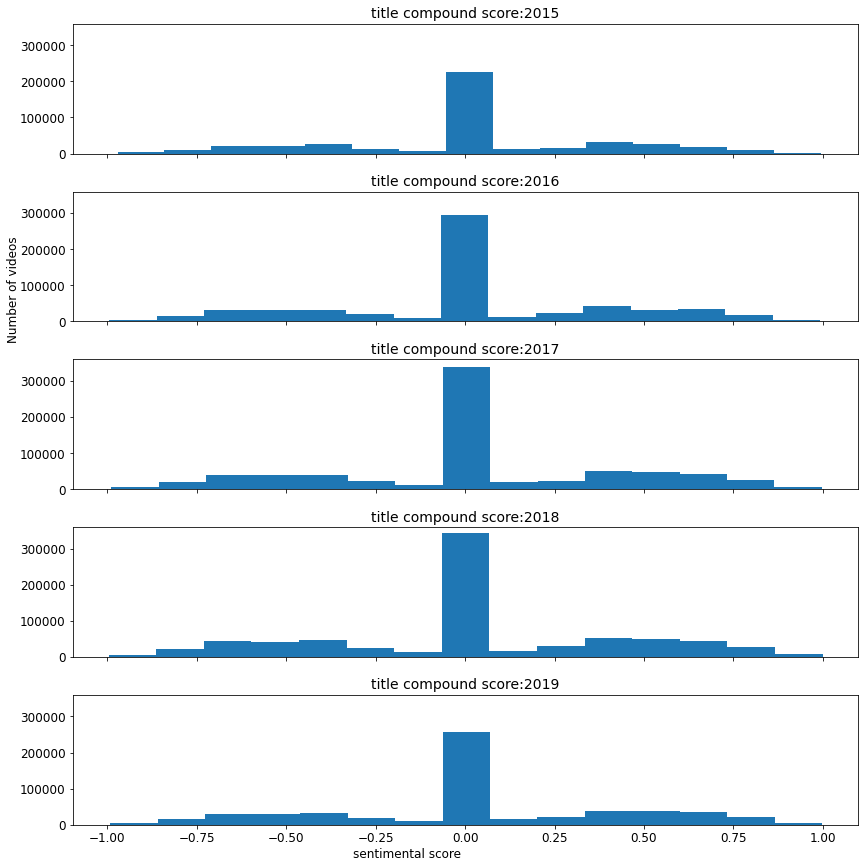

In [102]:
# Write your code to make 4x4 panel here

fig, ax = plt.subplots(5, 1,figsize= (12,12), sharey = True, sharex = True)

year = [2015, 2016, 2017, 2018, 2019]

for i in np.arange(5):
    sbplt = ax[i]
    sbplt.hist(video_metadatas[video_metadatas['yearNumber'] == year[i] ].title_com_scr,bins = 15)
    sbplt.set_title('title compound score:' + str(year[i]) )


fig.tight_layout()

fig.text(0.4,0, "sentimental score")
fig.text(0,0.6, "Number of videos", rotation = 90)

In [114]:
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr
1792,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True,0.672,0.00,0.328,0.6239
1793,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True,0.000,0.00,1.000,0.0000
1794,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,True,0.000,0.00,1.000,0.0000
1795,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,True,0.000,0.73,0.270,-0.8957
1796,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,True,0.198,0.00,0.802,0.5719


In [115]:
model_data = video_metadatas.loc[:,['title_com_scr', 'duration', 'weekNumber', 'view_count']]

In [117]:
# normalise the data
xmean = np.mean(model_data,axis=0)
xstd = np.std(model_data,axis=0)
Xbzs = (model_data-xmean)/xstd

In [119]:
# Declares the model
mod = smf.ols(formula='view_count ~ title_com_scr + duration + weekNumber', data=Xbzs)

In [120]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     187.1
Date:                Sun, 18 Dec 2022   Prob (F-statistic):          2.36e-121
Time:                        13:57:20   Log-Likelihood:            -4.4540e+06
No. Observations:             3139185   AIC:                         8.908e+06
Df Residuals:                 3139181   BIC:                         8.908e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.684e-10      0.001   1.18e-06

### Analyze the effect of the Capitalize words in title

Lets implement the sub question 2, the goal is to find a relation btw the number of views and the titles (length, sentiment, casefold, etc...). For that an observational studies would be highly recommended to compare what is comparable. For that we will keep the channel id to see the number of subs of the channel and compare pairwise similar nb of subs. 


In [126]:
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces
# don't have too many words and if there is a typo (e.g "Welcome,in my video" should be counted as 4 words and not 3)
def count_words(x: str):
    new_x = x.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip()
    return len(new_x.split(" "))

def get_freq_capital_words(sentence: str):
    new_x = sentence.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip().split(" ")
    nb_capital_words = 0
    for word in new_x:
        if word.isupper():
            nb_capital_words += 1
    return nb_capital_words / len(new_x)


In [124]:
video_metadatas["title_nb_words"] = title_metadatas.title.apply(
    lambda title: count_words(title)
)


video_metadatas["freq_capitalize_words"] = title_metadatas.title.apply(
    lambda title: get_freq_capital_words(title)
)


In [ ]:
# distrib of the freq capitalize words.
# process for the plot
freq_capit_words = round(video_metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")

In [ ]:
binary_freq_df = video_metadatas[
    (video_metadatas.freq_capitalize_words == 0)
    | (video_metadatas.freq_capitalize_words == 1)
]

no_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 0]
full_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 1]

In [ ]:
video_metadatas["view_count_log"] = np.log(video_metadatas.view_count, where=video_metadatas.view_count != 0)
mod = smf.ols(formula="view_count_log ~ title_nb_words + freq_capitalize_words", data=video_metadatas)
res = mod.fit()
print(res.summary())

In [33]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_filtered.feather")


In [37]:
title_metadatas.drop(["index", "categories"], axis=1, inplace=True)
title_metadatas.head(2)

,display_id,title
0,M0x6TJmMwL4,Blasphemous is Amazing!
1,ofAIp6dad00,I review all 42 Genesis Mini games


In [38]:
metadatas = pd.merge(video_metadatas, title_metadatas, on="display_id")


In [41]:
metadatas.sample()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title
630558,Gaming,2015-05-18,383,8.0,2.0,310.0,UCgJRhtnqA-67pKmQ3A2GsgA,16spHPsCzkI,2015,0,True,DCS Terrain Tool: Vary House AO - RU


In [42]:
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces
# don't have too many words and if there is a typo (e.g "Welcome,in my video" should be counted as 4 words and not 3)
def count_words(x: str):
    new_x = x.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip()
    return len(new_x.split(" "))


In [43]:
# test the function 
print(count_words("Salut     je suis la"))
print(count_words("Salut,je suis la"))
print(count_words("#FuckCancer | I'VE GOT SOME GREAT NEWS!"))
print(count_words("DISNEY CHRISTMAS VLOG! || Zak Longo"))
print(count_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(count_words("###ADA#ada##"))


4
4
7
5
10
2


In [44]:
metadatas["title_nb_words"] = metadatas.title.apply(
    lambda title: count_words(title)
)

In [45]:
def get_freq_capital_words(sentence: str):
    new_x = sentence.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip().split(" ")
    nb_capital_words = 0
    for word in new_x:
        if word.isupper():
            nb_capital_words += 1
    return nb_capital_words / len(new_x)


print(get_freq_capital_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(get_freq_capital_words("###ADA###salut|||test&SALUT"))


0.5
0.5


In [46]:
metadatas["freq_capitalize_words"] = metadatas.title.apply(
    lambda title: get_freq_capital_words(title)
)


In [47]:
metadatas.sample()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title,title_nb_words,freq_capitalize_words
1984289,Gaming,2017-03-31,10395,251.0,4.0,20737.0,UCJ2FGcjPBMrEx-bLC45nHLw,C3ekhuh0erI,2017,4,True,Kona | Full Playthrough | Longplay Gameplay Wa...,10,0.1


Text(0, 0.5, 'nb of titles')

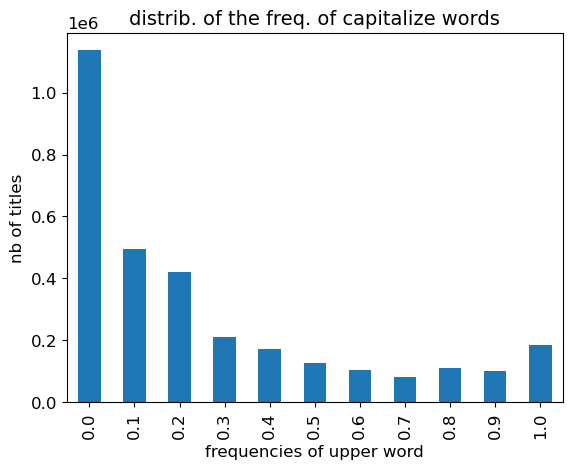

In [48]:
# distrib of the freq capitalize words.
# process for the plot
freq_capit_words = round(metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [54]:
binary_freq_df = metadatas[
    (metadatas.freq_capitalize_words == 0)
    | (metadatas.freq_capitalize_words == 1)
]

no_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 0]
full_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 1]

print("# of full upper words title", full_upper_word_df.shape)
print("# of full lower words title", no_upper_word_df.shape)

# of full upper words title (183480, 15)
# of full lower words title (1136521, 15)


In [51]:
# get the 
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming
1792,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True
1793,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True
1794,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,True
1795,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,True
1796,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,True


In [56]:
metadatas["view_count_log"] = np.log(metadatas.view_count, where=metadatas.view_count != 0)
mod = smf.ols(formula="view_count_log ~ title_nb_words + freq_capitalize_words", data=metadatas)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                 1.040e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:56:54   Log-Likelihood:            -7.2584e+06
No. Observations:             3139185   AIC:                         1.452e+07
Df Residuals:                 3139182   BIC:                         1.452e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.20

The frequence of capitalize words in the titles is significant and it increases the number of views on the video. \
The number of words in the title is significant, however it doesnt seem to have a real impact on the number of views. 


### Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?  
**Method:** We can implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  
**Organization:** Dorothee  

### Sub-Question 4
**Description:** What are the most common topics in each of the chosen categories?  
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022  
**Organization:** Jules  

### Sub-Question 5
**Description:** Does a channel's success increase with a greater variety of categories?  
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information and methods such as A/B testing and observational studies to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  
**Organization:** Paul  

Text(0, 0.5, 'Number of videos')

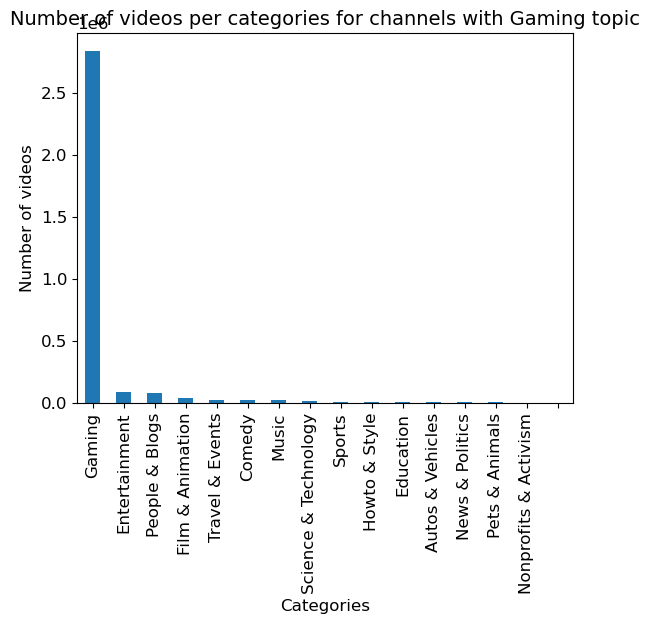

In [66]:
video_metadatas.categories.value_counts().plot(kind="bar")
plt.title("Number of videos per categories for channels with Gaming topic")
plt.xlabel("Categories")
plt.ylabel("Number of videos")


Find channels with unique topic


In [67]:
gaming_channels_with_categories = video_metadatas.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)
unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() == 1
]
non_unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Gaming : ", unique_topic_gaming.shape)
print("nb of channels without unique topic Gaming : ", non_unique_topic_gaming.shape)
unique_topic_gaming.value_counts()


nb of channels with unique topic Gaming :  (5598,)
nb of channels without unique topic Gaming :  (8782,)


[Gaming]              5576
[Entertainment]          8
[People & Blogs]         5
[Film & Animation]       4
[Education]              2
[Music]                  2
[Howto & Style]          1
dtype: int64

In [72]:
unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(unique_topic_gaming.index.values)
]
non_unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(non_unique_topic_gaming.index.values)
]


### Now we have the dataset to check the differences between unique and non unique categories channels


In [73]:
def get_confidence_interval(data):
    rng = np.random.default_rng()
    return bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        random_state=rng,
    ).confidence_interval


In [77]:
conf1 = get_confidence_interval(unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Gaming channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(non_unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for non unique Gaming channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


95% confidence interval of number of subs for unique Gaming channels [136_834, 161_374]
95% confidence interval of number of subs for non unique Gaming channels [131_541, 163_050]


From these statistics, we can notice that diverse channels have more subs in general. 
